In [1]:
import os
import glob
import datetime
# Import necessary packages.
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
# This is for the progress bar.
#from tqdm.auto import tqdm
import numpy as np
from tqdm import tqdm
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# train 裡的檔案 label 有改, 可以用 rename.ipynb 改
file_path = './train'
# file_path = 'test_data'
allFileList = glob.glob(os.path.join(file_path, '*'))
# label to numeric
dict_ = {}
with open("training data dic.txt","r", encoding='utf8') as F:
    line = F.readlines()
    for i, ch in enumerate(line):
        dict_[ch.strip()] = i
dict_['isnull'] = len(line)

In [3]:
label_ = []
for s in allFileList:
    label_.append(s.split("_")[-1].split(".")[0])
label = []
for i in label_:
    if i in dict_:
        label.append(dict_[i])
    else:
        label.append(800)

In [4]:
class SquarePad:
    def __call__(self, image):
        c, h, w = image.shape
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, hp, vp, vp)
        m = nn.ConstantPad2d(padding, 1)
        return m(image)

In [5]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform, label):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)
        self.label = label
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        lab = self.label[idx]
        img = self.transform(img)
        return (img, lab)

    def __len__(self):
        return self.num_samples

def get_dataset(root, label_):
    fnames = []
    label = []
    fnames_ = glob.glob(os.path.join(root, '*'))
    for i in range(len(fnames_)):
        #if int(fnames_[i].split('\\')[-1].split('_')[0]) < 10021 or 19999 < int(fnames_[i].split('\\')[-1].split('_')[0]) < 50001 or int(fnames_[i].split('\\')[-1].split('_')[0]) > 59999:
        fnames.append(fnames_[i])
        label.append(label_[i])
    #[print(fnames[i]) for i in range(5)]
    #[print(i) for i in range(len(fnames)) if fnames[i] == './train\\956_柏.jpg']
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    # add grayscale
    compose = [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        SquarePad(),
        transforms.Resize((64, 64)),
#         transforms.Resize((100, 100)),
#         transforms.CenterCrop((64, 64)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform, label)
    return dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


38
tensor(1.)
tensor(-0.9656)


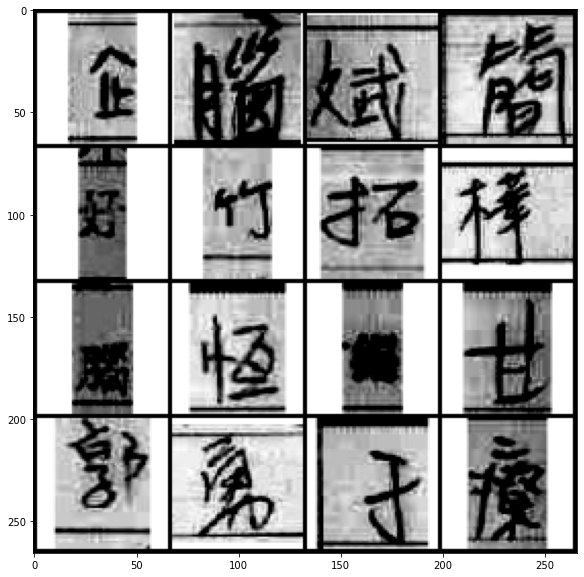

In [6]:
dataset = get_dataset(file_path, label)
images = [dataset[i][0] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [7]:
#print(len(dataset))
#print([int(len(dataset)*0.9), int(len(dataset)*0.1)])
train_set, valid_set = torch.utils.data.random_split(dataset,[int(len(dataset)*0.9), int(len(dataset)*0.1)])

### Parameter

In [8]:
batch_size = 128
lr = 1e-4

In [9]:
# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
#test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

### Model

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            #nn.ReLU(),
            nn.RReLU(0.001, 0.005),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            #nn.ReLU(),
            nn.RReLU(0.001, 0.005),
            nn.MaxPool2d(2, 2, 0),
            
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(256, 801),
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)
        #print(x.shape)
        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Initialize a model, and put it on the device specified.
# PATH = 'best_model_cnn_2.pth'
model = Classifier()
# model.load_state_dict(torch.load(PATH))
model.to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

# The number of training epochs.
n_epochs = 80

cuda


In [12]:
#start_time = datetime.datetime.now()
best_acc = 0
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    if best_acc < valid_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model_.pth')
        print('saving the best model')
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    #print(datetime.datetime.now()-start_time)
torch.save(model.state_dict(), 'last_model_.pth')

  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 001/060 ] loss = 6.03145, acc = 0.23410


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.80it/s]

saving the best model
[ Valid | 001/060 ] loss = 2.75300, acc = 0.46816


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.90it/s]

[ Train | 002/060 ] loss = 2.61077, acc = 0.48224


  0%|▏                                                                                 | 1/469 [00:00<00:49,  9.37it/s]

saving the best model
[ Valid | 002/060 ] loss = 2.14183, acc = 0.56397


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.27it/s]

[ Train | 003/060 ] loss = 2.04505, acc = 0.56578


  0%|▏                                                                                 | 1/469 [00:00<00:56,  8.36it/s]

saving the best model
[ Valid | 003/060 ] loss = 1.83246, acc = 0.62795


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.73it/s]

[ Train | 004/060 ] loss = 1.68029, acc = 0.62704


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.72it/s]

saving the best model
[ Valid | 004/060 ] loss = 1.63888, acc = 0.66303


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.93it/s]

[ Train | 005/060 ] loss = 1.42835, acc = 0.67521


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

saving the best model
[ Valid | 005/060 ] loss = 1.57350, acc = 0.67541


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.34it/s]

[ Train | 006/060 ] loss = 1.22447, acc = 0.71984


  0%|▏                                                                                 | 1/469 [00:00<00:49,  9.46it/s]

saving the best model
[ Valid | 006/060 ] loss = 1.45192, acc = 0.69811


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.66it/s]

[ Train | 007/060 ] loss = 1.05869, acc = 0.75347


  0%|▏                                                                                 | 1/469 [00:00<00:54,  8.64it/s]

saving the best model
[ Valid | 007/060 ] loss = 1.39334, acc = 0.70106


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.61it/s]

[ Train | 008/060 ] loss = 0.92451, acc = 0.78470


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.80it/s]

saving the best model
[ Valid | 008/060 ] loss = 1.36590, acc = 0.71624


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.93it/s]

[ Train | 009/060 ] loss = 0.80260, acc = 0.81379


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.72it/s]

saving the best model
[ Valid | 009/060 ] loss = 1.33125, acc = 0.72302


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.08it/s]

[ Train | 010/060 ] loss = 0.69903, acc = 0.83937


  0%|▏                                                                                 | 1/469 [00:00<00:54,  8.64it/s]

saving the best model
[ Valid | 010/060 ] loss = 1.29148, acc = 0.73349


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.39it/s]

[ Train | 011/060 ] loss = 0.60901, acc = 0.85953


  0%|▏                                                                                 | 1/469 [00:00<00:49,  9.55it/s]

saving the best model
[ Valid | 011/060 ] loss = 1.28431, acc = 0.73379


  4%|███▏                                                                               | 2/53 [00:00<00:05,  9.73it/s]

[ Train | 012/060 ] loss = 0.53177, acc = 0.87689


  0%|▏                                                                                 | 1/469 [00:00<00:56,  8.29it/s]

[ Valid | 012/060 ] loss = 1.29843, acc = 0.73025


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.26it/s]

[ Train | 013/060 ] loss = 0.46439, acc = 0.89257


  0%|▏                                                                                 | 1/469 [00:00<00:55,  8.50it/s]

saving the best model
[ Valid | 013/060 ] loss = 1.28107, acc = 0.73496


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.90it/s]

[ Train | 014/060 ] loss = 0.40356, acc = 0.90801


  0%|▏                                                                                 | 1/469 [00:00<00:56,  8.36it/s]

saving the best model
[ Valid | 014/060 ] loss = 1.24150, acc = 0.74882


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 015/060 ] loss = 0.35045, acc = 0.92159


  0%|▏                                                                                 | 1/469 [00:00<00:54,  8.65it/s]

[ Valid | 015/060 ] loss = 1.30039, acc = 0.73688


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.33it/s]

[ Train | 016/060 ] loss = 0.30763, acc = 0.93102


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.72it/s]

[ Valid | 016/060 ] loss = 1.28838, acc = 0.74116


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.37it/s]

[ Train | 017/060 ] loss = 0.27599, acc = 0.93827


  0%|▏                                                                                 | 1/469 [00:00<00:48,  9.73it/s]

[ Valid | 017/060 ] loss = 1.26329, acc = 0.74381


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.84it/s]

[ Train | 018/060 ] loss = 0.23638, acc = 0.94889


  0%|▏                                                                                 | 1/469 [00:00<00:50,  9.28it/s]

[ Valid | 018/060 ] loss = 1.30534, acc = 0.72745


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.67it/s]

[ Train | 019/060 ] loss = 0.21105, acc = 0.95429


  0%|▏                                                                                 | 1/469 [00:00<00:49,  9.37it/s]

[ Valid | 019/060 ] loss = 1.28316, acc = 0.74661


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.64it/s]

[ Train | 020/060 ] loss = 0.18608, acc = 0.96023


  0%|▏                                                                                 | 1/469 [00:00<00:56,  8.36it/s]

saving the best model
[ Valid | 020/060 ] loss = 1.28250, acc = 0.74926


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.44it/s]

[ Train | 021/060 ] loss = 0.16845, acc = 0.96482


  0%|▏                                                                                 | 1/469 [00:00<00:48,  9.73it/s]

[ Valid | 021/060 ] loss = 1.31314, acc = 0.73998


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 022/060 ] loss = 0.14744, acc = 0.97020


  0%|▎                                                                                 | 2/469 [00:00<00:49,  9.41it/s]

[ Valid | 022/060 ] loss = 1.29437, acc = 0.74587


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.52it/s]

[ Train | 023/060 ] loss = 0.13495, acc = 0.97299


  0%|▏                                                                                 | 1/469 [00:00<00:49,  9.37it/s]

saving the best model
[ Valid | 023/060 ] loss = 1.31395, acc = 0.74971


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 024/060 ] loss = 0.12218, acc = 0.97526


  0%|▏                                                                                 | 1/469 [00:00<00:58,  8.02it/s]

[ Valid | 024/060 ] loss = 1.32524, acc = 0.74396


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.93it/s]

[ Train | 025/060 ] loss = 0.11504, acc = 0.97754


  0%|▏                                                                                 | 1/469 [00:00<00:51,  9.03it/s]

saving the best model
[ Valid | 025/060 ] loss = 1.30918, acc = 0.75236


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.27it/s]

[ Train | 026/060 ] loss = 0.10059, acc = 0.98084


  0%|▎                                                                                 | 2/469 [00:00<00:50,  9.30it/s]

[ Valid | 026/060 ] loss = 1.33310, acc = 0.74381


  4%|███▏                                                                               | 2/53 [00:00<00:04, 12.38it/s]

[ Train | 027/060 ] loss = 0.09546, acc = 0.98103


  0%|▏                                                                                 | 1/469 [00:00<00:54,  8.64it/s]

saving the best model
[ Valid | 027/060 ] loss = 1.30315, acc = 0.75251


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.55it/s]

[ Train | 028/060 ] loss = 0.08679, acc = 0.98359


  0%|▏                                                                                 | 1/469 [00:00<00:51,  9.03it/s]

[ Valid | 028/060 ] loss = 1.34139, acc = 0.75044


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.93it/s]

[ Train | 029/060 ] loss = 0.08312, acc = 0.98360


  0%|▏                                                                                 | 1/469 [00:00<00:59,  7.90it/s]

[ Valid | 029/060 ] loss = 1.36531, acc = 0.73452


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 030/060 ] loss = 0.07827, acc = 0.98455


  0%|▏                                                                                 | 1/469 [00:00<00:54,  8.65it/s]

[ Valid | 030/060 ] loss = 1.35792, acc = 0.74779


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.02it/s]

[ Train | 031/060 ] loss = 0.07163, acc = 0.98614


  0%|▏                                                                                 | 1/469 [00:00<00:54,  8.64it/s]

[ Valid | 031/060 ] loss = 1.39019, acc = 0.73747


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.52it/s]

[ Train | 032/060 ] loss = 0.06788, acc = 0.98716


  0%|▏                                                                                 | 1/469 [00:00<00:57,  8.09it/s]

saving the best model
[ Valid | 032/060 ] loss = 1.36278, acc = 0.75472


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.02it/s]

[ Train | 033/060 ] loss = 0.06857, acc = 0.98656


  0%|▏                                                                                 | 1/469 [00:00<00:52,  8.95it/s]

[ Valid | 033/060 ] loss = 1.39336, acc = 0.74602


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.93it/s]

[ Train | 034/060 ] loss = 0.06235, acc = 0.98727


  0%|▏                                                                                 | 1/469 [00:00<00:49,  9.37it/s]

[ Valid | 034/060 ] loss = 1.36199, acc = 0.75236


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.93it/s]

[ Train | 035/060 ] loss = 0.05826, acc = 0.98880


  0%|▏                                                                                 | 1/469 [00:00<00:59,  7.90it/s]

[ Valid | 035/060 ] loss = 1.40093, acc = 0.73614


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.66it/s]

[ Train | 036/060 ] loss = 0.05459, acc = 0.98930


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.72it/s]

[ Valid | 036/060 ] loss = 1.36065, acc = 0.75383


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.73it/s]

[ Train | 037/060 ] loss = 0.05454, acc = 0.98914


  0%|▏                                                                                 | 1/469 [00:00<00:51,  9.12it/s]

[ Valid | 037/060 ] loss = 1.35949, acc = 0.75339


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.61it/s]

[ Train | 038/060 ] loss = 0.05355, acc = 0.98908


  0%|▏                                                                                 | 1/469 [00:00<00:55,  8.50it/s]

[ Valid | 038/060 ] loss = 1.41564, acc = 0.73157


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.55it/s]

[ Train | 039/060 ] loss = 0.05050, acc = 0.98937


  0%|▏                                                                                 | 1/469 [00:00<00:55,  8.50it/s]

saving the best model
[ Valid | 039/060 ] loss = 1.34480, acc = 0.75693


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.02it/s]

[ Train | 040/060 ] loss = 0.04763, acc = 0.99030


  0%|▏                                                                                 | 1/469 [00:00<00:54,  8.57it/s]

[ Valid | 040/060 ] loss = 1.40494, acc = 0.74749


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.34it/s]

[ Train | 041/060 ] loss = 0.04489, acc = 0.99110


  0%|▏                                                                                 | 1/469 [00:00<00:51,  9.12it/s]

[ Valid | 041/060 ] loss = 1.37877, acc = 0.75442


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 042/060 ] loss = 0.04783, acc = 0.98966


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

[ Valid | 042/060 ] loss = 1.43208, acc = 0.72671


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 043/060 ] loss = 0.04361, acc = 0.99170


  0%|▏                                                                                 | 1/469 [00:00<00:59,  7.83it/s]

[ Valid | 043/060 ] loss = 1.42413, acc = 0.75044


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 044/060 ] loss = 0.04326, acc = 0.99070


  0%|▏                                                                                 | 1/469 [00:00<00:49,  9.37it/s]

[ Valid | 044/060 ] loss = 1.41346, acc = 0.73438


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.90it/s]

[ Train | 045/060 ] loss = 0.03933, acc = 0.99202


  0%|▏                                                                                 | 1/469 [00:00<00:55,  8.36it/s]

[ Valid | 045/060 ] loss = 1.48262, acc = 0.73880


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.72it/s]

[ Train | 046/060 ] loss = 0.03897, acc = 0.99180


  0%|▏                                                                                 | 1/469 [00:00<00:55,  8.50it/s]

[ Valid | 046/060 ] loss = 1.39893, acc = 0.75369


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.78it/s]

[ Train | 047/060 ] loss = 0.03787, acc = 0.99192


  0%|▏                                                                                 | 1/469 [00:00<00:48,  9.64it/s]

[ Valid | 047/060 ] loss = 1.45780, acc = 0.73098


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 048/060 ] loss = 0.03802, acc = 0.99211


  0%|▏                                                                                 | 1/469 [00:00<00:47,  9.83it/s]

[ Valid | 048/060 ] loss = 1.39136, acc = 0.75486


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.73it/s]

[ Train | 049/060 ] loss = 0.03767, acc = 0.99196


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.72it/s]

[ Valid | 049/060 ] loss = 1.41398, acc = 0.75634


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.55it/s]

[ Train | 050/060 ] loss = 0.03425, acc = 0.99259


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.72it/s]

[ Valid | 050/060 ] loss = 1.44480, acc = 0.75074


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 051/060 ] loss = 0.03636, acc = 0.99177


  0%|▎                                                                                 | 2/469 [00:00<00:46, 10.03it/s]

[ Valid | 051/060 ] loss = 1.45958, acc = 0.73275


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.61it/s]

[ Train | 052/060 ] loss = 0.03532, acc = 0.99216


  0%|▏                                                                                 | 1/469 [00:00<00:50,  9.28it/s]

saving the best model
[ Valid | 052/060 ] loss = 1.41598, acc = 0.75737


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.28it/s]

[ Train | 053/060 ] loss = 0.03535, acc = 0.99180


  0%|▎                                                                                 | 2/469 [00:00<00:47,  9.93it/s]

[ Valid | 053/060 ] loss = 2.08336, acc = 0.73791


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.72it/s]

[ Train | 054/060 ] loss = 0.03241, acc = 0.99325


  0%|▏                                                                                 | 1/469 [00:00<00:50,  9.20it/s]

[ Valid | 054/060 ] loss = 1.46532, acc = 0.75103


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.83it/s]

[ Train | 055/060 ] loss = 0.03164, acc = 0.99285


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.80it/s]

[ Valid | 055/060 ] loss = 1.44452, acc = 0.75369


  2%|█▌                                                                                 | 1/53 [00:00<00:05,  9.64it/s]

[ Train | 056/060 ] loss = 0.02975, acc = 0.99331


  0%|▏                                                                                 | 1/469 [00:00<00:55,  8.43it/s]

[ Valid | 056/060 ] loss = 1.43310, acc = 0.74175


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.02it/s]

[ Train | 057/060 ] loss = 0.02979, acc = 0.99338


  0%|▏                                                                                 | 1/469 [00:00<00:58,  7.96it/s]

saving the best model
[ Valid | 057/060 ] loss = 1.42149, acc = 0.76607


  4%|███▏                                                                               | 2/53 [00:00<00:04, 10.67it/s]

[ Train | 058/060 ] loss = 0.03009, acc = 0.99360


  0%|▏                                                                                 | 1/469 [00:00<00:53,  8.80it/s]

[ Valid | 058/060 ] loss = 1.63811, acc = 0.73423


  4%|███▏                                                                               | 2/53 [00:00<00:04, 11.08it/s]

[ Train | 059/060 ] loss = 0.02836, acc = 0.99410


  0%|▏                                                                                 | 1/469 [00:00<00:56,  8.36it/s]

[ Valid | 059/060 ] loss = 1.53275, acc = 0.74116


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

[ Train | 060/060 ] loss = 0.02856, acc = 0.99348


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 11.09it/s]

[ Valid | 060/060 ] loss = 1.45796, acc = 0.76253
